!pip install monai
import monai

Main package: https://monai.io/

Dataset: http://medicaldecathlon.com/

Broad Outline:

*   Preprocessing: Load the dataset, crop to the brain region, normalize the intensity range, and resample to a consistent voxel spacing
*   Dataset preparation: Create training, validation, and test datasets from the preprocessed images and labels.
*   Model training: Define and train a 3D U-Net model using the training dataset and a Dice Loss function
*   Inference: Use the trained model to perform segmentation on new unseen images from the test dataset.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.0 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import numpy as np
import tempfile
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch
'''
Additional dependencies will be required, refer to: https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies
MONAI: MONAI is an open-source deep learning library for medical imaging developed by Project MONAI.
It is built on top of PyTorch and provides many utilities and pre-built components specifically for medical image analysis.
'''
# To install all the dependencies for monai (contains all the required ML packages from numpy, pandas to
# imagecodecs etc)
'''
Run:
git clone https://github.com/Project-MONAI/MONAI.git
cd MONAI/
pip install -e '.[all]'

from terminal (native or colab)
'''

"\nRun:\ngit clone https://github.com/Project-MONAI/MONAI.git\ncd MONAI/\npip install -e '.[all]'\n\nfrom terminal (native or colab)\n"

In [ ]:
#lib, packages and version check
print_config()

MONAI version: 1.1.0
Numpy version: 1.22.4
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.2
gdown version: 4.6.6
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
# Sets the random seed of numpy and pytorch to a fixed value.
# This ensures that the results are reproducable

def set_determinism(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Medical Label Segmentation
Brain tumour labels needs to converted into multi label segmentations.

In the BraTS dataset BraTS dataset, there are four different tumor classes:
*   Edema- label #1
*   Non-enhancing tumor core- label #2
*   Enhancing tumor core- label #3
*   Necrosis- label #4

For ML imaging requiring we need to convert the above medical classess into distinct channels in order to increase accuracy, diagnosis, treatment and planning. These channels are:

*   Tumor Core- label #2 and #3
*   Whole tumor- label #1, #2, and #3
*   Enhancing tumor- label #2


So, in summary, this transform takes in the original label data which has four classes, and creates three new binary channels representing Tumor Core, Whole Tumor, and Enhancing Tumor. This transform can be useful for the segmentation of brain tumors into these specific classes, which is important for accurate diagnosis, treatment planning, and prognosis.







In [ ]:
# Read the doc string or Monai map transform details

'''
Maptransform- is a MONAI class that is used as the base class for most transform functions. This class defines the required attributes
and methods that every transform should have.
- It is applied to a dict of data, it is used for data augmentation, pre-processing and post-processing.
- The MapTransform class has two main methods:
(1) __call__: This method is called when an instance of the class is called as a function. It takes the input dictionary of data as input and
returns the transformed dictionary of data. WILL BE USING THIS
(2) inverse: This method is used to compute the inverse transform of the original transform. It is useful when we need to undo the effect of
a transform on the data, for example, to evaluate the performance of a model after applying the transform

- KEYS specifies which input data is to be transformed.

By inheriting from the MapTransform class, a user can define a custom transform that is compatible with the MONAI library and can be easily
integrated into a data processing pipeline
'''
class convert_multi_channel(MapTransform): #taking in map transform as the parent class
  def __call__(self, data):
    dict_data= dict(data) #converting the data into a dict format and naming it as dict_data
    for key in self.keys:  #loops to each key in self.keys specifying which data is to be transformed
      output= [] #multi channel label data to be stored in output list
      #Creating the tumor core label if the data has a key corresponding to 2 or 3. Transformed data
      output.append(torch.logical_or(dict_data[key] == 2, dict_data[key] == 3))
      #Creating the Whole tumor label if thr data has the key corresponding to 2, 3, or 1
      output.append(torch.logical_or(torch.logical_or(dict_data[key] == 2, dict_data[key] == 3), dict_data[key] == 1))
      # Creating the enhancing tumor label if the key has a value corresponding to 2
      output.append(dict_data[key] == 2)
      # the varioud multi chanel labels are stacked together from the appended output, assigned to float.
      # stored as the keys of the dict
      dict_data[key] = torch.stack(output, axis=0).float()
    return dict_data #transformed dictionary

# Transforms for training and validation
## Overview
Voxel == pixels: can have one or more channels that represent different features of the data

Channel first- Organizing these channels as the first dim of the image tensor, and then followed by spatial dims such as height, width and depth.

Use previously defined class convert_multi_channels we convert the original single-channel label map inot a multi channel label map (as defined in the above code block)

RAS- Right Anterior Superior orientation. Ensures all the image data has the same orientation irrespective of the orientation they were captured in originally. This makes the model more accurate

## Transform and Train
Inputing the data, ensuring channel fist, multi-class conversion, and RAS conversion.
1.   Rescaling pixel spacing
2.   Random cropping the images
3.   Random image flipping
4.   Normalizing the intensity (scaling and shifting the image intensity)







In [ ]:
#Old one with full memory
'''
mode arg is used for specifying the interpolation, we use two such methods.
Bilinear- interpolation that estimated new pixel values by calculating the weightes avg of the 4 nearest pixels. Used for resampling FOR IMAGE
nearest- assigns the value of the closest pixel to the new cordinate FOR LABEL
'''
TrainingTransformation = Compose(
    [
        LoadImaged(keys=["image", "label"]), #load the data and specify that the keys are the data(image) and the label
        EnsureChannelFirstd(keys="image"), #channel first- image is the first dimension followed by the spatial orinetation
        EnsureTyped(keys=["image", "label"]), #ensuring dtype
        convert_multi_channel(keys="label"), #multi label transformation
        Orientationd(keys=["image", "label"], axcodes="RAS"), #specifies RAS orientation
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")), #spacing and interpolation for label and image,
        #ref: doc string
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False), #randomly crop image, all same size
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0), #random flipping with prob=0.5 for exis 1
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1), #random flipping with prob=0.5 for exis 2
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2), #random flipping with prob=0.5 for exis 3
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True), #normalization to only non-zero pixels, applied to all channels/ features
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0), #random scale
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0), #random shit
    ]
)

'''
Validation should be processed without any randomnes
'''
ValidationTransformation = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        convert_multi_channel(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

# Loading Data
Data Source: http://medicaldecathlon.com/

Contains the brats glioma tumour images

Steps:
*   Downloaded from the above link
*   Uploaded on drive
*   dir path set and specified

json file describes the train and test


DecathlonDataset contains the BraTS data which we automatically download directed by the file path and data stored in the drive. To reduce high memory usage we've set cache_rate to 0. Need to download the data just once for training, not required for validation



In [ ]:
#from monai.data.image_reader import NibabelReader

data_dir_drive= "/content/drive/MyDrive/Colab_Notebooks/Project"
data_train = DecathlonDataset(
    root_dir= data_dir_drive,
    task="Task01_BrainTumour",
    transform=TrainingTransformation,
    #transform=Compose([LoadImaged(keys=["image", "label"], reader=NibabelReader())]),
    section="training",
    download=False,
    cache_rate= 0,
    num_workers=5,
)

train_loader = DataLoader(data_train, batch_size=1, num_workers= 2, shuffle=True)


In [ ]:
'''
data_dir_drive= "/content/drive/MyDrive/Colab_Notebooks/Project"

data_train = DecathlonDataset(
    root_dir= data_dir_drive,
    task="Task01_BrainTumour",
    transform=TrainingTransformation,
    #transform=Compose([LoadImaged(keys=["image", "label"], reader=NibabelReader())]),
    section="training",
    download=True,
    cache_rate= 0,
    num_workers=5,
)

max_split_size_mb = 2000 # set the maximum split size in MB

train_loader = DataLoader(data_train, batch_size=1, shuffle=True, max_split_size=max_split_size_mb)
'''

'\ndata_dir_drive= "/content/drive/MyDrive/Colab_Notebooks/Project"\n\ndata_train = DecathlonDataset(\n    root_dir= data_dir_drive,\n    task="Task01_BrainTumour",\n    transform=TrainingTransformation,\n    #transform=Compose([LoadImaged(keys=["image", "label"], reader=NibabelReader())]),\n    section="training",\n    download=True,\n    cache_rate= 0,\n    num_workers=5,\n)\n\nmax_split_size_mb = 2000 # set the maximum split size in MB\n\ntrain_loader = DataLoader(data_train, batch_size=1, shuffle=True, max_split_size=max_split_size_mb)\n'

In [ ]:
data_validate = DecathlonDataset(
    root_dir= data_dir_drive,
    task="Task01_BrainTumour",
    transform= ValidationTransformation,
    section="validation",
    download=False,
    cache_rate= 0,
    num_workers= 5,
)

validate_loader = DataLoader(data_validate, batch_size=1, num_workers=2, shuffle=True)

In [ ]:
!ls /content/drive/MyDrive/Colab_Notebooks/Project//Task01_BrainTumour/

dataset.json  imagesTr	imagesTs  labelsTr


image shape: torch.Size([4, 224, 224, 144])


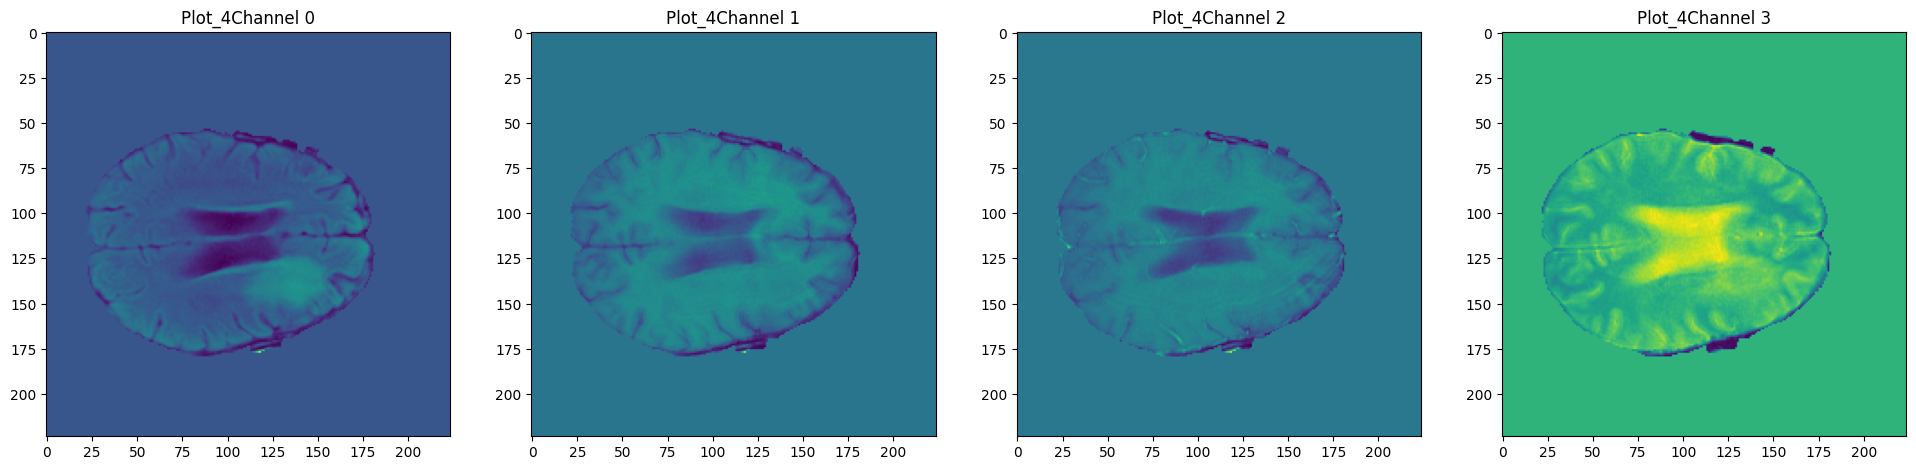

In [ ]:
# 4 channel
# Check the various channels by sampling a random image data and label from the training data set
data_sample= data_train[random.randint(0, len(data_train)-1)] #random image
print(f"image shape: {data_sample['image'].shape}") #print shape
plt.figure("Plot_4Channel", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Plot_4Channel {i}")
    plt.imshow(data_sample["image"][i, :, :, 60].detach().cpu())
plt.show()

label shape: torch.Size([3, 224, 224, 144])


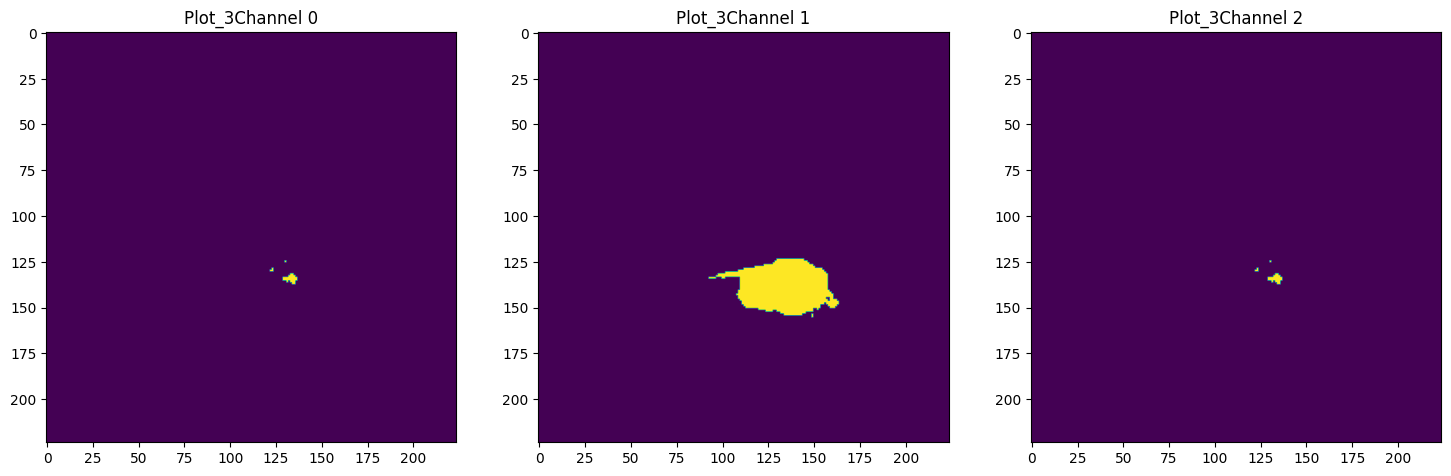

In [ ]:
# 3 chanel for the same random sample
print(f"label shape: {data_sample['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"Plot_3Channel {i}")
    plt.imshow(data_sample["label"][i, :, :, 60].detach().cpu())
plt.show()

# Model Creation

In [ ]:
#Clearing cache from cloud server to reduce memory constraints
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [ ]:
max_epochs = 10
val_interval= 1
VAL_AMP = True #Tensor Cores available in NVIDIA GPUs to speed up the training process.

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
'''
blocks down- int number of residual blocks at each downsampling stage of the network
blocks up- int number of residual blocks at each upsampleing stage of the networ
init_filters- filters in the first convolution layer
in_channels- number of channels
out_channels- number of output channels
'''
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=24,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
#Dice loss- measure of the overlap b/w predicted and ground truth segmentation task
loss_function = DiceLoss(smooth_nr=0, smooth_dr=0.001, squared_pred=True, to_onehot_y=False, sigmoid=True)
'''def loss_function(outputs, targets):
    with torch.cuda.amp.autocast():
        loss = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)(outputs, targets)
    return loss'''
#Adan optimizer- adaptive learning rate optimizer
optimizer = torch.optim.Adam(model.parameters(), 0.001, weight_decay=0.001)
# Defines the learning scheduler- CosineAnnealingLR, reduces the learning rate according to the cosine annealing schedule.
# mac epochs is set to T_max
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
dice_metric = DiceMetric(include_background=True, reduction="mean")
'''
Defines the evaluation metric(s) to use during validation.
Dice coefficient- measure of overlap between the predicted and ground truth segmentation masks.
The include_background parameter is set to True to include the background class in the calculation.
reduction specifies how to reduce the metric over batches and samples
'''
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
# Post processing transform
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
'''
Sliding window inference
'''
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(64, 64, 32),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# Gradient scaling during training to prevent overflow and underflow of tensor values
scaler = torch.cuda.amp.GradScaler()
# Faster performance
torch.backends.cudnn.benchmark = False

# Training

Training a neural net model for segmentation. Training it for a specific number of epochs- T_max.

Iterate over number of epochs, trains model. For each batch:
- Send to device

- Resets optimizer

- Forward propagation, loss calculation, and backward propagation on the model using the input data and the labels, and obtains the outputs and loss. AMP is used to improve the speed and efficiency of training by using lower precision for some calculations without sacrificing accuracy.

- Compute epoch loss

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []


total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(data_train) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in validate_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(data_dir_drive, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/10


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/388, train_loss: 0.7587, step time: 0.5789
2/388, train_loss: 0.5281, step time: 0.5470
3/388, train_loss: 0.6511, step time: 0.5779
4/388, train_loss: 0.5399, step time: 0.5467
5/388, train_loss: 0.5938, step time: 0.5838
6/388, train_loss: 0.5030, step time: 0.5671
7/388, train_loss: 0.4308, step time: 0.5887
8/388, train_loss: 0.7570, step time: 0.5687
9/388, train_loss: 0.5486, step time: 0.5470
10/388, train_loss: 0.5518, step time: 0.5865
11/388, train_loss: 0.4821, step time: 0.5474
12/388, train_loss: 0.6457, step time: 0.5806
13/388, train_loss: 0.3913, step time: 0.5530
14/388, train_loss: 0.5291, step time: 0.5712
15/388, train_loss: 0.5638, step time: 0.5486
16/388, train_loss: 0.5724, step time: 0.5515
17/388, train_loss: 0.4917, step time: 0.5487
18/388, train_loss: 0.5508, step time: 0.5848
19/388, train_loss: 0.5425, step time: 0.5502
20/388, train_loss: 0.4619, step time: 0.5745
21/388, train_loss: 0.2449, step time: 0.5499
22/388, train_loss: 0.5268, step time: 0.57

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

saved new best metric model
current epoch: 1 current mean dice: 0.3215 tc: 0.3176 wt: 0.4642 et: 0.1828
best mean dice: 0.3215 at epoch: 1
time consuming of epoch 1 is: 1323.9319
----------
epoch 2/10


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/388, train_loss: 0.5330, step time: 0.5774
2/388, train_loss: 0.5456, step time: 0.5516
3/388, train_loss: 0.8038, step time: 0.5768
4/388, train_loss: 0.6701, step time: 0.5474
5/388, train_loss: 0.4285, step time: 0.5738
6/388, train_loss: 0.6909, step time: 0.5606
7/388, train_loss: 0.8315, step time: 0.5759
8/388, train_loss: 0.6488, step time: 0.5503
9/388, train_loss: 0.7430, step time: 0.5801
10/388, train_loss: 0.6636, step time: 0.5535
11/388, train_loss: 0.9733, step time: 0.5466
12/388, train_loss: 0.9204, step time: 0.5518
13/388, train_loss: 0.9555, step time: 0.5744
14/388, train_loss: 0.8769, step time: 0.5486
15/388, train_loss: 0.7549, step time: 0.5516
16/388, train_loss: 0.7407, step time: 0.5479
17/388, train_loss: 0.7600, step time: 0.5738
18/388, train_loss: 0.5326, step time: 0.5513
19/388, train_loss: 0.4598, step time: 0.5640
20/388, train_loss: 0.5478, step time: 0.5504
21/388, train_loss: 0.5973, step time: 0.5487
22/388, train_loss: 0.7904, step time: 0.54

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

current epoch: 2 current mean dice: 0.1735 tc: 0.1836 wt: 0.3069 et: 0.0300
best mean dice: 0.3215 at epoch: 1
time consuming of epoch 2 is: 897.6793
----------
epoch 3/10


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/388, train_loss: 0.7248, step time: 0.5682
2/388, train_loss: 0.6370, step time: 0.5505
3/388, train_loss: 0.8845, step time: 0.5802
4/388, train_loss: 0.7216, step time: 0.5497
5/388, train_loss: 0.9170, step time: 0.5812
6/388, train_loss: 0.8654, step time: 0.5516
7/388, train_loss: 0.7463, step time: 0.5783
8/388, train_loss: 0.5997, step time: 0.5458
9/388, train_loss: 0.9529, step time: 0.5477
10/388, train_loss: 0.6410, step time: 0.5491
11/388, train_loss: 0.9023, step time: 0.5485
12/388, train_loss: 0.7551, step time: 0.5486
13/388, train_loss: 0.6561, step time: 0.5803
14/388, train_loss: 0.9274, step time: 0.5484
15/388, train_loss: 0.7001, step time: 0.5490
16/388, train_loss: 0.7957, step time: 0.5463
17/388, train_loss: 0.8762, step time: 0.5788
18/388, train_loss: 0.7750, step time: 0.5524
19/388, train_loss: 0.9028, step time: 0.5460
20/388, train_loss: 0.7958, step time: 0.5465
21/388, train_loss: 0.7475, step time: 0.5577
22/388, train_loss: 0.7262, step time: 0.56

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

current epoch: 3 current mean dice: 0.0852 tc: 0.0867 wt: 0.1655 et: 0.0034
best mean dice: 0.3215 at epoch: 1
time consuming of epoch 3 is: 897.7831
----------
epoch 4/10


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/388, train_loss: 0.8395, step time: 0.5766
2/388, train_loss: 0.9555, step time: 0.5575
3/388, train_loss: 0.9648, step time: 0.5515
4/388, train_loss: 0.8737, step time: 0.5576
5/388, train_loss: 0.9603, step time: 0.5826
6/388, train_loss: 0.9152, step time: 0.5620
7/388, train_loss: 0.8448, step time: 0.5775
8/388, train_loss: 0.9050, step time: 0.5571
9/388, train_loss: 0.8405, step time: 0.5531
10/388, train_loss: 0.8573, step time: 0.5624
11/388, train_loss: 0.9266, step time: 0.5554
12/388, train_loss: 0.8921, step time: 0.5562
13/388, train_loss: 0.7997, step time: 0.5773
14/388, train_loss: 0.8888, step time: 0.5565
15/388, train_loss: 0.8501, step time: 0.5505
16/388, train_loss: 0.8951, step time: 0.5584
17/388, train_loss: 0.9829, step time: 0.5831
18/388, train_loss: 0.9307, step time: 0.5528
19/388, train_loss: 0.8766, step time: 0.5748
20/388, train_loss: 0.8904, step time: 0.5545
21/388, train_loss: 0.8163, step time: 0.5506
22/388, train_loss: 0.9114, step time: 0.55

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

current epoch: 4 current mean dice: 0.0474 tc: 0.0390 wt: 0.1008 et: 0.0025
best mean dice: 0.3215 at epoch: 1
time consuming of epoch 4 is: 897.2206
----------
epoch 5/10


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/388, train_loss: 0.9025, step time: 0.5786
2/388, train_loss: 0.8900, step time: 0.5532
3/388, train_loss: 0.8661, step time: 0.5559
4/388, train_loss: 0.9674, step time: 0.5600
5/388, train_loss: 0.8945, step time: 0.5903
6/388, train_loss: 0.9086, step time: 0.5568
7/388, train_loss: 0.8494, step time: 0.5841
8/388, train_loss: 0.9199, step time: 0.5601
9/388, train_loss: 0.9496, step time: 0.5538
10/388, train_loss: 0.8433, step time: 0.5558
11/388, train_loss: 0.8668, step time: 0.5616
12/388, train_loss: 0.8539, step time: 0.5544
13/388, train_loss: 0.9242, step time: 0.5729
14/388, train_loss: 0.8735, step time: 0.5543
15/388, train_loss: 0.9416, step time: 0.5581
16/388, train_loss: 0.9097, step time: 0.5566
17/388, train_loss: 0.9233, step time: 0.5543
18/388, train_loss: 0.9567, step time: 0.5531
19/388, train_loss: 0.9737, step time: 0.5819
20/388, train_loss: 0.9216, step time: 0.5558
21/388, train_loss: 0.9068, step time: 0.5775
22/388, train_loss: 0.8425, step time: 0.55

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using sto

current epoch: 5 current mean dice: 0.0321 tc: 0.0219 wt: 0.0726 et: 0.0018
best mean dice: 0.3215 at epoch: 1
time consuming of epoch 5 is: 901.2756
----------
epoch 6/10


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/388, train_loss: 0.9124, step time: 0.5969
2/388, train_loss: 0.8606, step time: 0.5685
3/388, train_loss: 0.9334, step time: 0.5875
4/388, train_loss: 0.9193, step time: 0.5596
5/388, train_loss: 0.9697, step time: 0.5631
6/388, train_loss: 0.9170, step time: 0.5583
7/388, train_loss: 0.8913, step time: 0.5759
8/388, train_loss: 0.9723, step time: 0.5575
9/388, train_loss: 0.9143, step time: 0.5604
10/388, train_loss: 0.9366, step time: 0.5618
11/388, train_loss: 0.8768, step time: 0.5587
12/388, train_loss: 0.9600, step time: 0.5666
13/388, train_loss: 0.9504, step time: 0.5760
14/388, train_loss: 0.8327, step time: 0.5630
15/388, train_loss: 0.9455, step time: 0.5560
16/388, train_loss: 0.9210, step time: 0.5604
17/388, train_loss: 0.9530, step time: 0.5790
18/388, train_loss: 0.8832, step time: 0.5613
19/388, train_loss: 0.9532, step time: 0.5948
20/388, train_loss: 0.9271, step time: 0.5570
21/388, train_loss: 0.8447, step time: 0.5584
22/388, train_loss: 0.9252, step time: 0.55

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

current epoch: 6 current mean dice: 0.0217 tc: 0.0151 wt: 0.0493 et: 0.0007
best mean dice: 0.3215 at epoch: 1
time consuming of epoch 6 is: 899.8980
----------
epoch 7/10


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/388, train_loss: 0.9238, step time: 0.6016
2/388, train_loss: 0.9660, step time: 0.5630
3/388, train_loss: 0.8738, step time: 0.5857
4/388, train_loss: 0.9479, step time: 0.5625
5/388, train_loss: 0.8946, step time: 0.5904
6/388, train_loss: 0.9304, step time: 0.5605
7/388, train_loss: 0.9745, step time: 0.5573
8/388, train_loss: 0.8969, step time: 0.5621
9/388, train_loss: 0.9629, step time: 0.5575
10/388, train_loss: 0.9890, step time: 0.5610
11/388, train_loss: 0.9740, step time: 0.5560
12/388, train_loss: 0.9654, step time: 0.5595
13/388, train_loss: 0.9809, step time: 0.5738
14/388, train_loss: 0.9680, step time: 0.5616
15/388, train_loss: 0.9221, step time: 0.5589
16/388, train_loss: 0.8605, step time: 0.5594
17/388, train_loss: 0.8932, step time: 0.5855
18/388, train_loss: 0.9222, step time: 0.5608
19/388, train_loss: 0.9545, step time: 0.5762
20/388, train_loss: 0.9665, step time: 0.5587
21/388, train_loss: 0.9195, step time: 0.5670
22/388, train_loss: 0.9467, step time: 0.55

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

current epoch: 7 current mean dice: 0.0166 tc: 0.0124 wt: 0.0370 et: 0.0004
best mean dice: 0.3215 at epoch: 1
time consuming of epoch 7 is: 897.3844
----------
epoch 8/10


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/388, train_loss: 0.9600, step time: 0.5922
2/388, train_loss: 0.9125, step time: 0.5590
3/388, train_loss: 0.9316, step time: 0.5595
4/388, train_loss: 0.9565, step time: 0.5588
5/388, train_loss: 0.9475, step time: 0.5897
6/388, train_loss: 0.9133, step time: 0.5645
7/388, train_loss: 0.9691, step time: 0.5794
8/388, train_loss: 0.9738, step time: 0.5600
9/388, train_loss: 0.9320, step time: 0.5568
10/388, train_loss: 0.9272, step time: 0.5632
11/388, train_loss: 0.9469, step time: 0.5821
12/388, train_loss: 0.9664, step time: 0.5585
13/388, train_loss: 0.9671, step time: 0.5868
14/388, train_loss: 0.9235, step time: 0.5562
15/388, train_loss: 0.8653, step time: 0.5606
16/388, train_loss: 0.9652, step time: 0.5605
17/388, train_loss: 0.9192, step time: 0.5604
18/388, train_loss: 0.9496, step time: 0.5562
19/388, train_loss: 0.9141, step time: 0.5581
20/388, train_loss: 0.9791, step time: 0.5580
21/388, train_loss: 0.8905, step time: 0.5582
22/388, train_loss: 0.9299, step time: 0.55

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

current epoch: 8 current mean dice: 0.0136 tc: 0.0109 wt: 0.0297 et: 0.0002
best mean dice: 0.3215 at epoch: 1
time consuming of epoch 8 is: 902.3796
----------
epoch 9/10


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/388, train_loss: 0.9886, step time: 0.6001
2/388, train_loss: 0.9614, step time: 0.5587
3/388, train_loss: 0.9542, step time: 0.5579
4/388, train_loss: 0.8931, step time: 0.5573
5/388, train_loss: 0.9050, step time: 0.5935
6/388, train_loss: 0.9842, step time: 0.5610
7/388, train_loss: 0.8447, step time: 0.5824
8/388, train_loss: 0.9394, step time: 0.5637
9/388, train_loss: 0.9269, step time: 0.5576
10/388, train_loss: 0.9580, step time: 0.5639
11/388, train_loss: 0.9450, step time: 0.5617
12/388, train_loss: 0.9361, step time: 0.5637
13/388, train_loss: 0.9470, step time: 0.5639
14/388, train_loss: 0.9821, step time: 0.5618
15/388, train_loss: 0.9691, step time: 0.5598
16/388, train_loss: 0.9885, step time: 0.5614
17/388, train_loss: 0.9297, step time: 0.5560
18/388, train_loss: 0.9200, step time: 0.5634
19/388, train_loss: 0.8891, step time: 0.5634
20/388, train_loss: 0.9338, step time: 0.5608
21/388, train_loss: 0.9160, step time: 0.5622
22/388, train_loss: 0.9280, step time: 0.56

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

current epoch: 9 current mean dice: 0.0122 tc: 0.0102 wt: 0.0263 et: 0.0002
best mean dice: 0.3215 at epoch: 1
time consuming of epoch 9 is: 900.8490
----------
epoch 10/10


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/388, train_loss: 0.9595, step time: 0.5810
2/388, train_loss: 0.8604, step time: 0.5636
3/388, train_loss: 0.9534, step time: 0.5588
4/388, train_loss: 0.9415, step time: 0.5622
5/388, train_loss: 0.9472, step time: 0.5793
6/388, train_loss: 0.9567, step time: 0.5605
7/388, train_loss: 0.9352, step time: 0.5812
8/388, train_loss: 0.9527, step time: 0.5657
9/388, train_loss: 0.9322, step time: 0.5593
10/388, train_loss: 0.8836, step time: 0.5574
11/388, train_loss: 0.9392, step time: 0.5603
12/388, train_loss: 0.9383, step time: 0.5637
13/388, train_loss: 0.9431, step time: 0.5920
14/388, train_loss: 0.8910, step time: 0.5628
15/388, train_loss: 0.9865, step time: 0.5635
16/388, train_loss: 0.9878, step time: 0.5601
17/388, train_loss: 0.9412, step time: 0.5606
18/388, train_loss: 0.9712, step time: 0.5595
19/388, train_loss: 0.9547, step time: 0.5890
20/388, train_loss: 0.9598, step time: 0.5632
21/388, train_loss: 0.9528, step time: 0.5905
22/388, train_loss: 0.9196, step time: 0.56

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

current epoch: 10 current mean dice: 0.0118 tc: 0.0100 wt: 0.0253 et: 0.0002
best mean dice: 0.3215 at epoch: 1
time consuming of epoch 10 is: 902.2762


In [ ]:
# Clearing cache from cloud server to reduce memory constraints
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 755034 KiB |  15461 MiB | 605197 GiB | 605196 GiB |\n|       from large pool | 721910 KiB |  15432 MiB | 595926 GiB | 595925 GiB |\n|       from small pool |  33124 KiB |     56 MiB |   9270 GiB |   9270 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 755034 KiB |  15461 MiB | 605197 GiB | 605196 GiB |\n|       from large pool | 721910 KiB |  15432 MiB |

In [ ]:
#Post training outputs
# Required for plottting the graphs and metrics for comparison
# What are we plotting?
'''
Average loss (error) of the model during training for each epoch (training iteration)
he second plot on the right shows the mean Dice score (a measure of accuracy) of the model on the validation dataset,
calculated after a certain number of epochs called "val_interval".
Mean Dice score, but for each of the three tumor classes separately: TC (tumor core), WT (whole tumor),
and ET (enhancing tumor). Each plot shows the metric for each epoch on the x-axis and the corresponding metric value
on the y-axis, in a different color for each class.
'''
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.3215 at epoch: 1, total time: 9420.678821325302.


# Plotting the Metric and Loss

[nan, 0.7434751627985964, 0.8567563266176539, 0.9021588619222346, 0.9132922092049393, 0.9262907925954799, 0.9377403889120239, 0.9444965548122052, 0.94655124443708, 0.9494639645839474]
[0.3215468227863312, 0.173492893576622, 0.08521189540624619, 0.04743276908993721, 0.03212117776274681, 0.021708479151129723, 0.016584297642111778, 0.013606391847133636, 0.012201089411973953, 0.011797918938100338]
[0.31757810711860657, 0.1835712343454361, 0.08674944192171097, 0.039019253104925156, 0.02190721593797207, 0.015130012296140194, 0.012350932694971561, 0.010888170450925827, 0.010177604854106903, 0.009961063042283058]
[0.464231938123703, 0.3069453537464142, 0.16551963984966278, 0.10079280287027359, 0.07264670729637146, 0.04930802807211876, 0.03701898083090782, 0.029692595824599266, 0.02625928819179535, 0.02527829073369503]
[0.18283040821552277, 0.02996213175356388, 0.003366591176018119, 0.0024862708523869514, 0.001809596666134894, 0.0006873978418298066, 0.0003829778579529375, 0.00023841059010010213

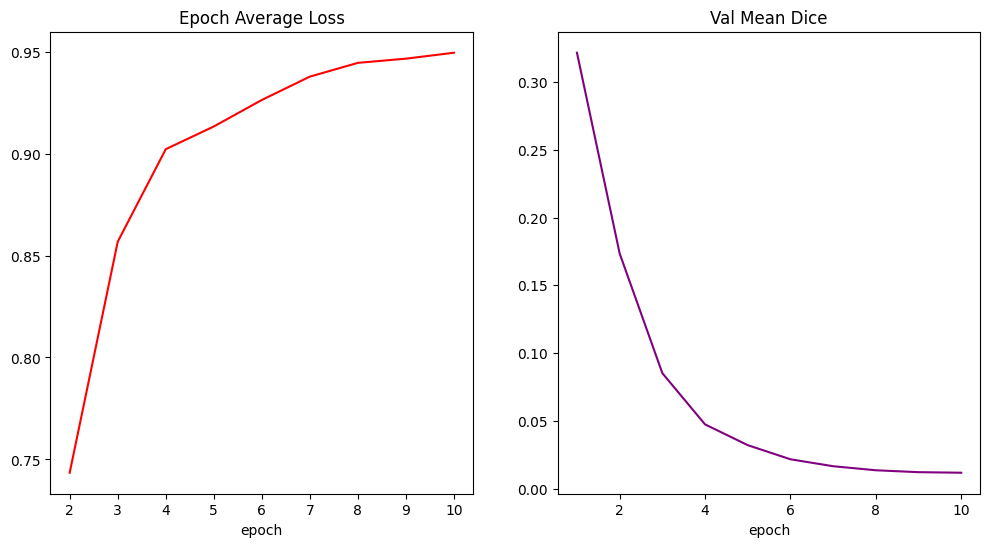

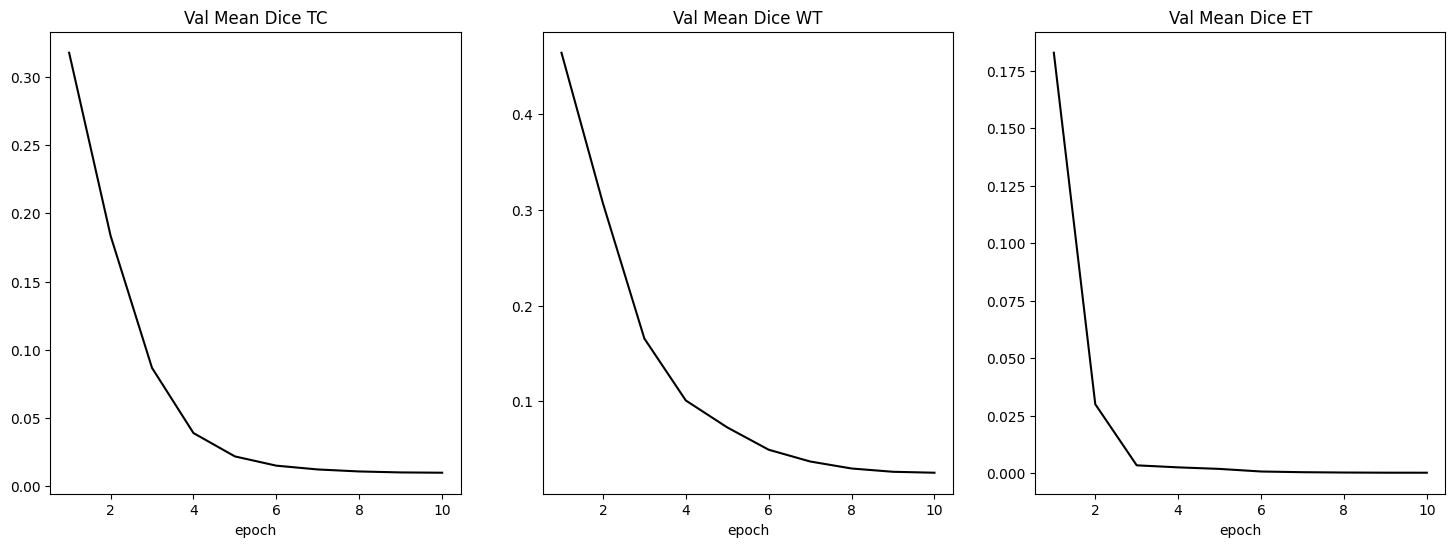

In [ ]:
print(epoch_loss_values)
print(metric_values)
print(metric_values_tc)
print(metric_values_wt)
print(metric_values_et)

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="black")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="black")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="black")
plt.show()

# Best model Output
best_metric_model.pth loaded and it is used to evaluate the prediction of a random sample from the validation set.

Post processing applied for transformation. Matplotlib is then used to viz. the output, grounf truth labels and predicted labels.

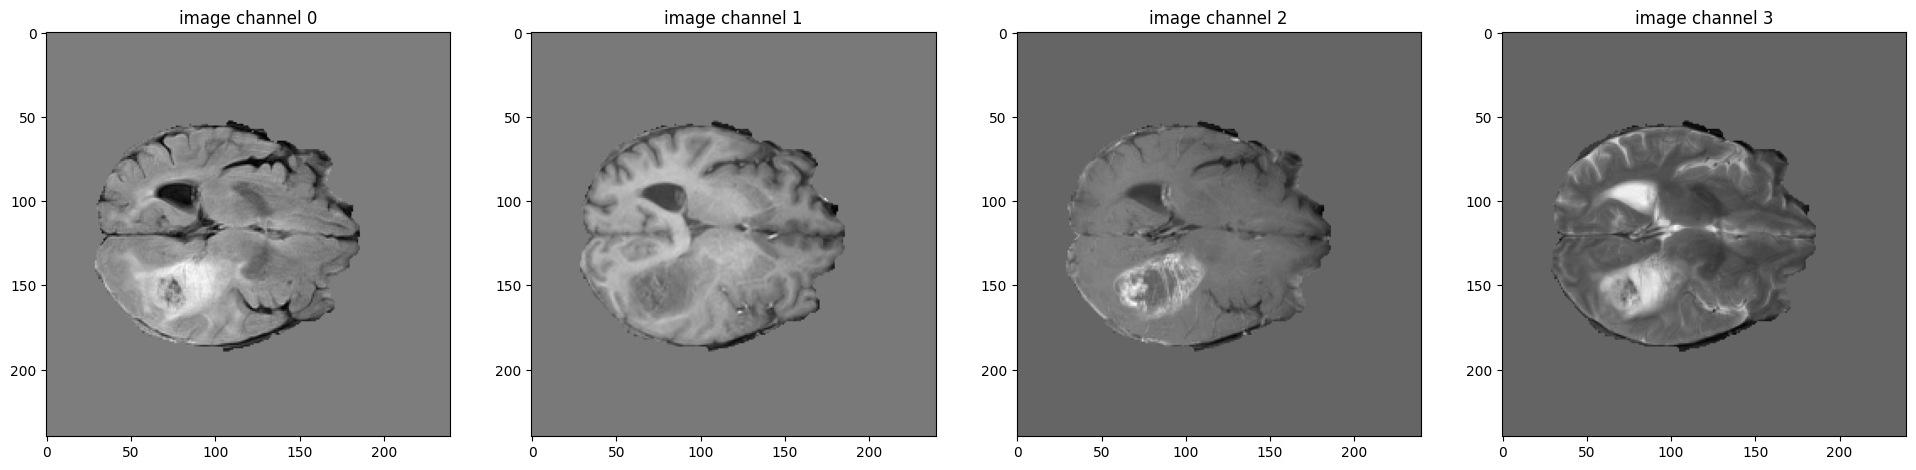

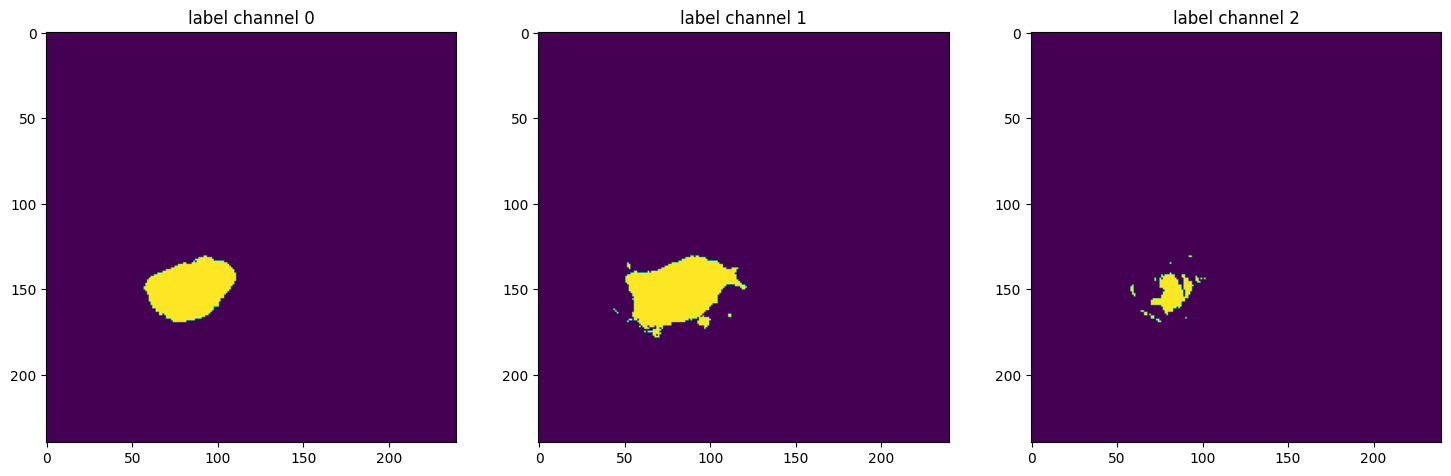

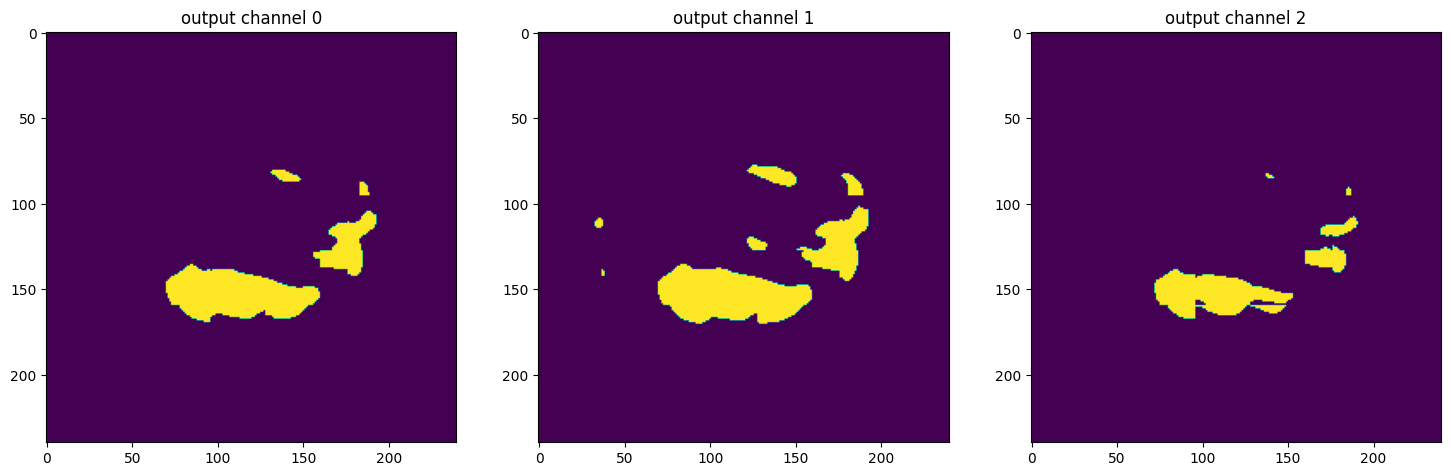

In [ ]:
model.load_state_dict(torch.load(os.path.join(data_dir_drive, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = data_validate[random.randint(0, len(data_validate)-1)]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(data_validate[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(data_validate[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

# Evaluation on original image spacings


In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        convert_multi_channel(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=data_dir_drive,n
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose(ch
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)
model.load_state_dict(torch.load(os.path.join(data_dir_drive, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

Metric on original image spacing:  0.3215468227863312
metric_tc: 0.3176
metric_wt: 0.4642
metric_et: 0.1828
